In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_map(attn_map,resnames):
# plot 4 layers of attention map
    fig,ax = plt.subplots(2,2,figsize=(12,10))

    for i in range(4):
        sns.heatmap(attn_map[i].squeeze().cpu().detach().numpy(),cmap='coolwarm',ax=ax[i//2,i%2])
        ax[i//2,i%2].set_title(f'layer {i+1}')
        # give each row and column a resname in the middle
        ax[i//2,i%2].set_xticks([i+0.5 for i in range(len(resnames))])
        ax[i//2,i%2].set_yticks([i+0.5 for i in range(len(resnames))])
        ax[i//2,i%2].set_xticklabels(resnames,rotation=90)
        ax[i//2,i%2].set_yticklabels(resnames,rotation=0)
        ax[i//2,i%2].set_xlabel('resname')
        ax[i//2,i%2].set_ylabel('resname')

        # set the space between subplots bigger
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        

    plt.show()

In [1]:
from geom2vec.data import Preprocessing
import torch

folder_path = '/project/dinner/zpengmei/prots/trpcage/features_256/vis_vs'
preprocess = Preprocessing(torch_or_numpy='numpy')
raw_dataset = preprocess.load_dataset(data_path=folder_path,mmap_mode='r',data_key='features_masked',to_torch=True)
dataset = torch.cat(raw_dataset,dim=0).to(torch.float32)
del raw_dataset
time_lagged_dataset = preprocess.create_time_lagged_dataset(dataset.to(torch.float32), lag_time=25)


/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 105/105 [01:15<00:00,  1.38it/s]


In [2]:
from torch.utils.data.dataloader import DataLoader

train_data, val_data = torch.utils.data.random_split(time_lagged_dataset, [int(0.8*len(time_lagged_dataset)), len(time_lagged_dataset)-int(0.8*len(time_lagged_dataset))])

print('train_data:', len(train_data))
print('val_data:', len(val_data))

train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1000, shuffle=False)

train_data: 417580
val_data: 104395


In [3]:
from geom2vec import Lobe
from geom2vec.downstream_models import VAMPNet
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Lobe(
    hidden_channels=256,
    intermediate_channels=256,
    output_channels=5,
    num_layers=2,
    batch_norm=True,
    vector_feature=True,
    mlp_dropout=0.2,
    mlp_out_activation=None,
    device=device,
    token_mixer = 'subformer',
    num_mixer_layers = 4,
    pooling = 'cls',
    dropout = 0.2,
    num_tokens = 10,
    token_dim = 64,
    attn_map= True
)

model = VAMPNet(
    lobe=net,
    learning_rate=1e-4,
    optimizer='Adam',
    device=device
)

model.fit(train_loader,n_epochs=50,validation_loader=val_loader,progress=tqdm,train_patience=1000,train_valid_interval=100,valid_patience=10)


epoch:   0%|                                                                                                                       | 0/50 [00:00<?, ?it/s]

0 4.285153388977051


0 4.9560866355896


0 5.0895915031433105


0 5.167253017425537


epoch:   2%|██▏                                                                                                         | 1/50 [02:08<1:44:34, 128.06s/it]

1 5.196680068969727


1 5.181636333465576


1 5.311358451843262


1 5.288424491882324


epoch:   4%|████▎                                                                                                       | 2/50 [04:10<1:39:52, 124.84s/it]

2 5.339487075805664


2 5.3813652992248535


2 5.382099628448486


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 363/418 [01:52<00:17,  3.22it/s]
                                                                                                                                                          

2 5.399490833282471
Validation patience reached at epoch 2


In [4]:
# save model object
# create a folder to save the model
import os
os.makedirs('/project/dinner/zpengmei/geom2vec/examples/Figures/Figure2a/trp/models/subformer',exist_ok=True)
torch.save(model, '/project/dinner/zpengmei/geom2vec/examples/Figures/Figure2a/trp/models/subformer/model_1.pt')

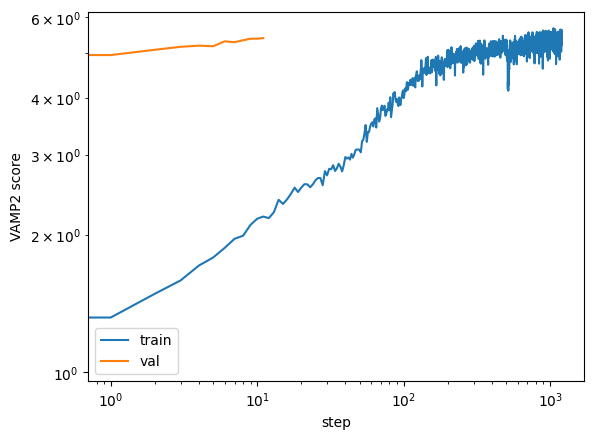

In [5]:
train_score = model.training_scores
val_score = model.validation_scores

import matplotlib.pyplot as plt

plt.loglog(train_score, label='train')
plt.loglog(val_score, label='val')
plt.xlabel('step')
plt.ylabel('VAMP2 score')
plt.legend()
plt.show()

In [6]:
cvs = model.transform(dataset,return_cv=True,lag_time=25,batch_size=1000)
os.makedirs('/project/dinner/zpengmei/geom2vec/examples/Figures/Figure2a/trp/cvs/subformer',exist_ok=True)
torch.save(cvs, '/project/dinner/zpengmei/geom2vec/examples/Figures/Figure2a/trp/cvs/subformer/cvs_1.pt')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 522/522 [00:13<00:00, 39.96it/s]


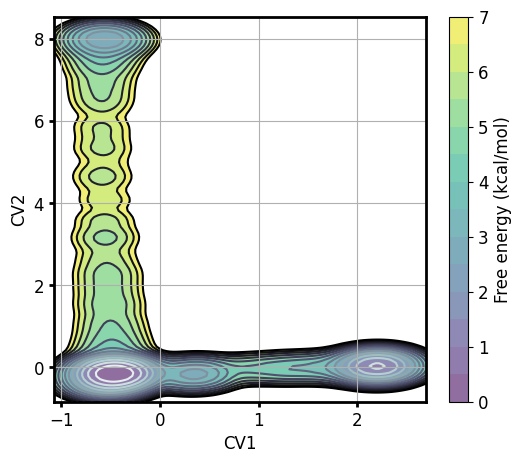

In [7]:
from geom2vec.utils import ContourPlot2D

fig,ax = plt.subplots(1,1,figsize=(6,5))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.xaxis.set_tick_params(labelsize=12,direction='out',width=2)
ax.yaxis.set_tick_params(labelsize=12,direction='out',width=2)
c = ContourPlot2D()
ax = c.plot(cvs[:,0:2][::5],ax,labelsize=12,xlabel='CV1',ylabel='CV2')

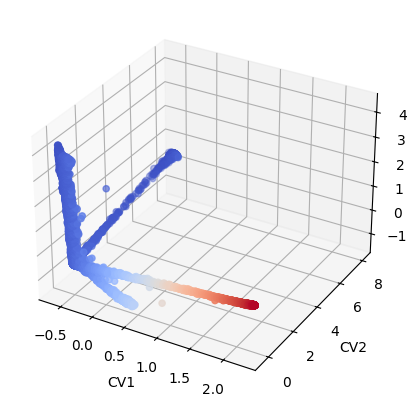

In [8]:
# 3d scatter plot using matplotlib
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cvs[:,0][::5],cvs[:,1][::5],cvs[:,2][::5],c=cvs[:,0][::5],cmap='coolwarm')
ax.set_xlabel('CV1')
ax.set_ylabel('CV2')
ax.set_zlabel('CV3')
plt.show()

In [15]:
# find indices with cv1 > 1
import numpy as np
idx = np.where(cvs[:,0]>1.5)[0]
print('total number of frames with cv1 > 1:', len(idx))
idx = np.random.choice(idx,50,replace=False)
idx

total number of frames with cv1 > 1: 89026


array([368498, 405771,  62100, 268697, 365871, 205773,  63858, 372912,
       406889,  57545,   4356,  50404, 154369, 406934, 519424, 197420,
        58913, 349875,   6041, 412849, 323983, 366342, 518625,  60186,
       362687, 351893,   5484, 205150,    469, 395365, 199284, 199017,
       268494, 410784, 347387, 372678, 521057, 345912, 371104, 406422,
         2967, 518997,  57208,  57915,  60737, 198617, 363341,  62682,
       323523,   5240])

In [9]:
import MDAnalysis as mda

topology_file = "/project/dinner/anton_data/TRP_cage/trpcage.pdb"
trajectory_file = "/project/dinner/anton_data/TRP_cage/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein/2JOF-0-protein-000.dcd" 

u = mda.Universe(topology_file, trajectory_file)
resnames = ['CLS']
for res in u.residues:
    resnames.append(res.resname)

/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


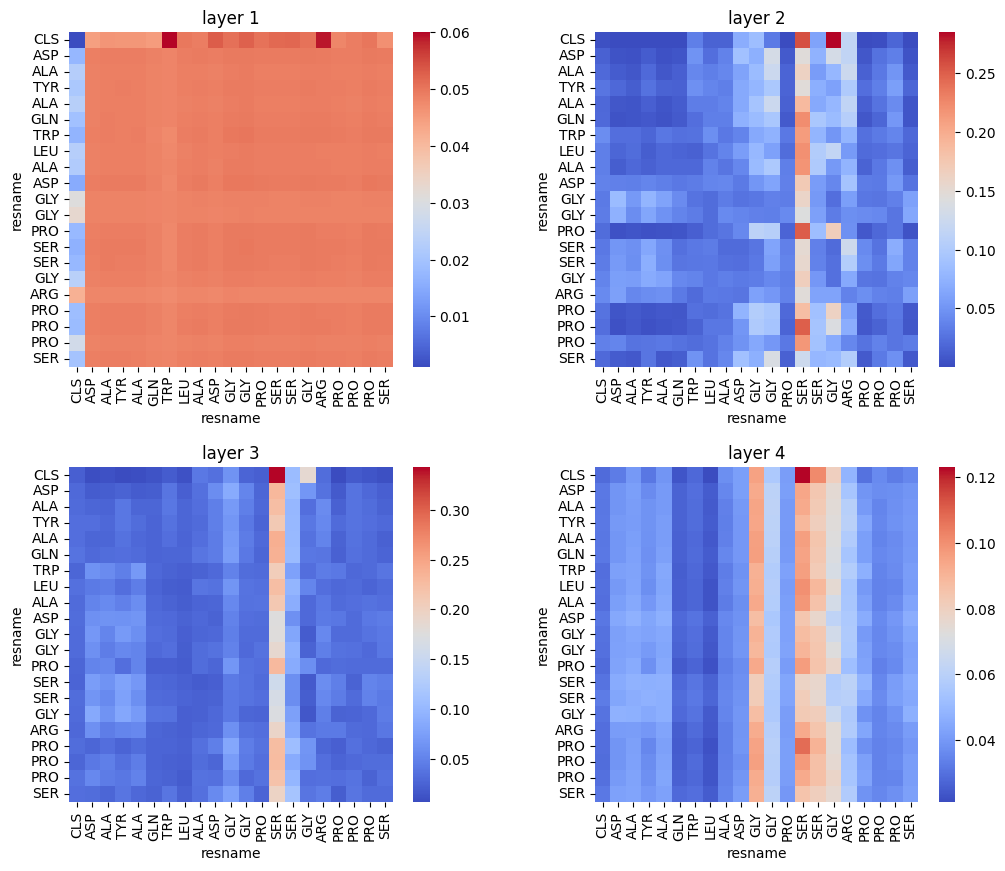

In [21]:
attn_map = net.fetch_attnmap(dataset[368498].unsqueeze(0).to(device))
plot_attention_map(attn_map,resnames)

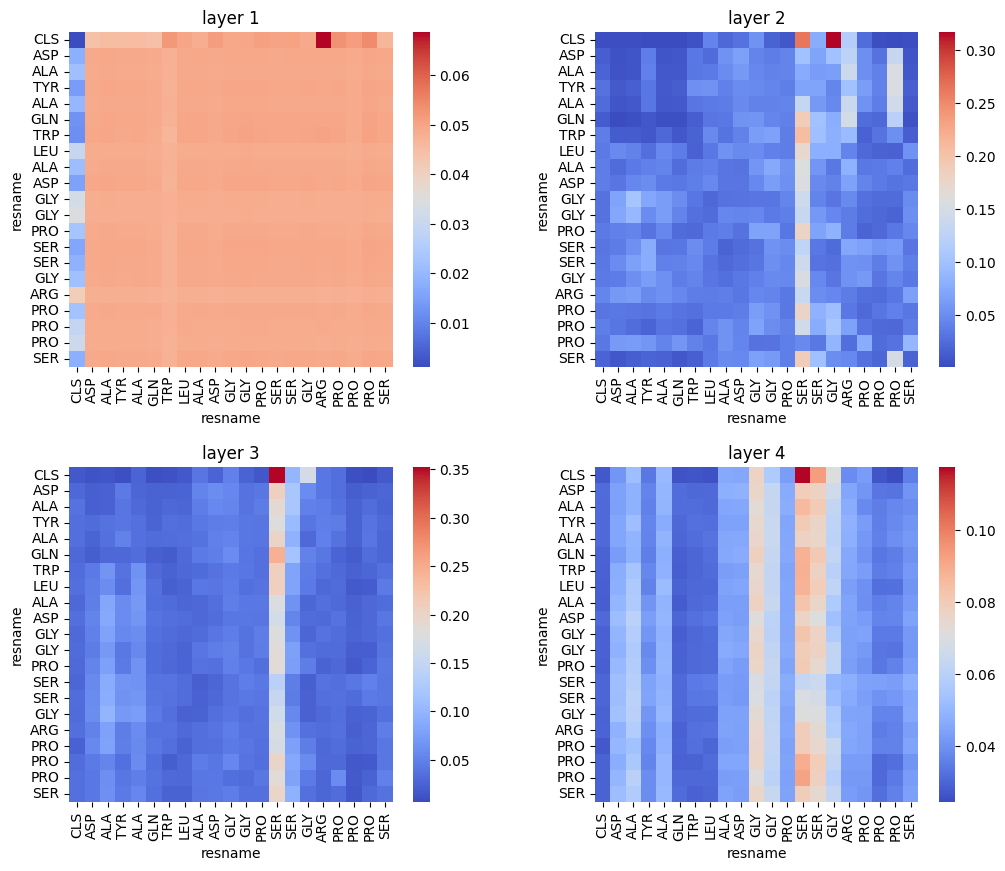

In [22]:
attn_map = net.fetch_attnmap(dataset[469].unsqueeze(0).to(device))
plot_attention_map(attn_map,resnames)

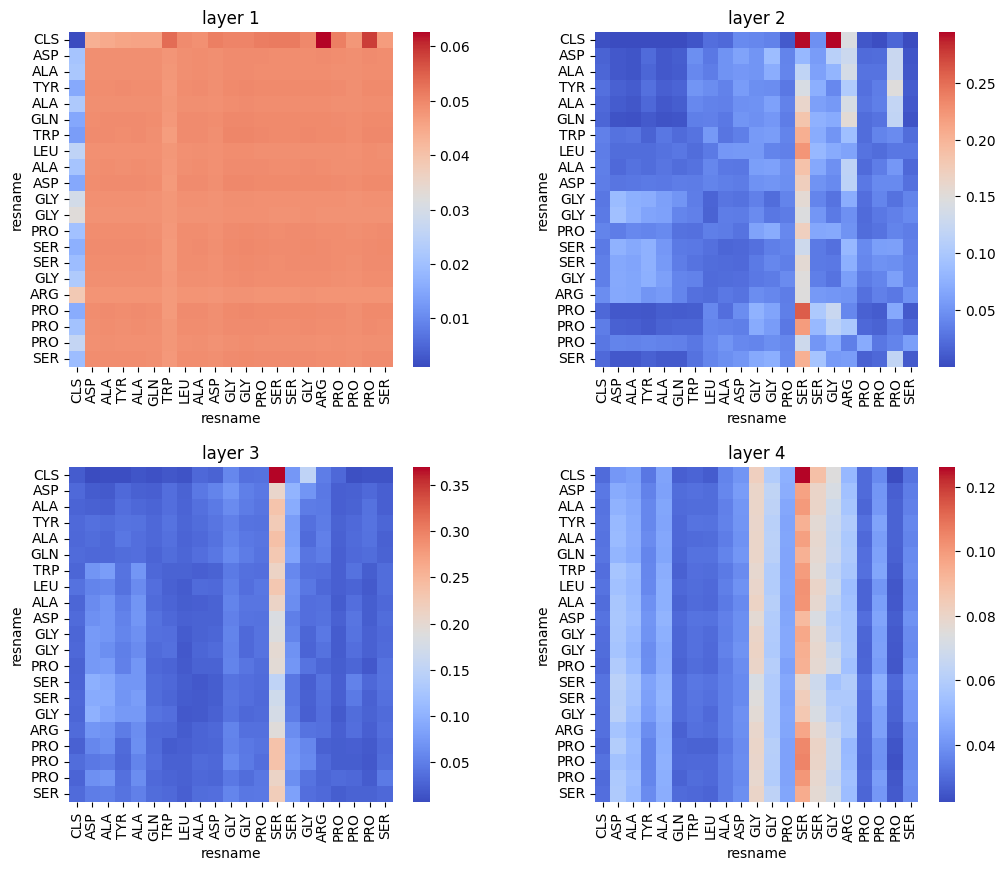

In [24]:
attn_map = net.fetch_attnmap(dataset[57545].unsqueeze(0).to(device))
plot_attention_map(attn_map,resnames)